Found 1433 images belonging to 10 classes.
Found 304 images belonging to 10 classes.
Found 316 images belonging to 10 classes.
training
Epoch 1/5


2025-04-04 16:54:08.365457: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


45/45 [==============================] - 2s 46ms/step - loss: 1.8436 - accuracy: 0.3531 - val_loss: 0.7371 - val_accuracy: 0.7928
Epoch 2/5
45/45 [==============================] - 2s 39ms/step - loss: 0.6945 - accuracy: 0.7634 - val_loss: 0.1802 - val_accuracy: 0.9243
Epoch 3/5
45/45 [==============================] - 2s 39ms/step - loss: 0.3022 - accuracy: 0.8995 - val_loss: 0.0660 - val_accuracy: 0.9836
Epoch 4/5
45/45 [==============================] - 2s 38ms/step - loss: 0.2215 - accuracy: 0.9239 - val_loss: 0.0760 - val_accuracy: 0.9836
Epoch 5/5
45/45 [==============================] - 2s 38ms/step - loss: 0.1529 - accuracy: 0.9512 - val_loss: 0.0563 - val_accuracy: 0.9868

Test Set Evaluation:
10/10 [==============================] - 0s 17ms/step - loss: 0.0086 - accuracy: 1.0000
Test Accuracy: 100.00%

Training samples (with augmentation):


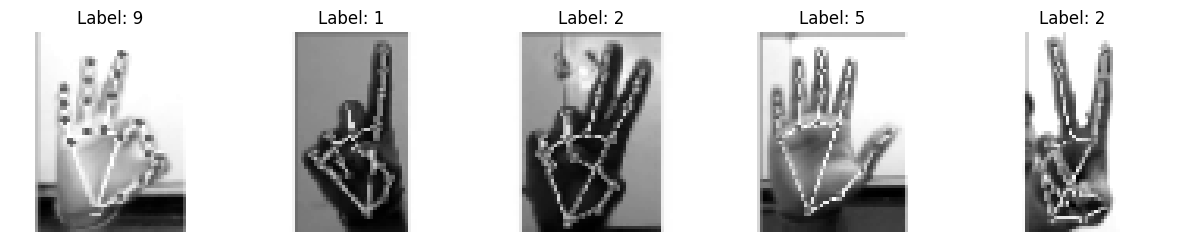


Validation samples (no augmentation):


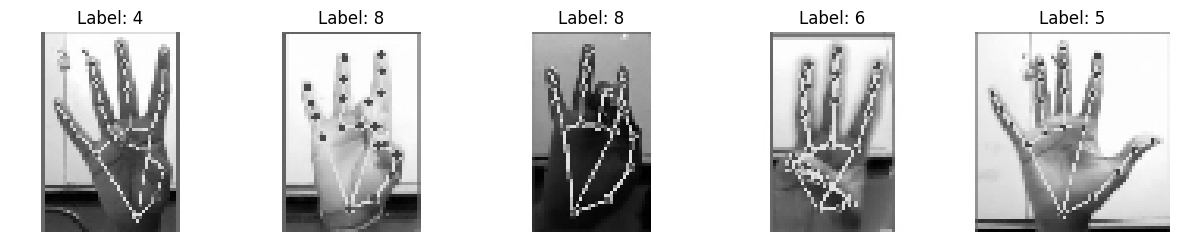

In [1]:
# Import libraries
import numpy as np
import splitfolders
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Dataset Preprocessing and Splitting
# --------------------------------------------

# Split dataset into train (70%), val (15%), test (15%)
input_folder = "C:/Users/crite/Downloads/digitsData"
output_folder = "preprocessed_digitsData"
# splitfolders.ratio(
#     input_folder,
#     output=output_folder,
#     seed=42,
#     ratio=(0.7, 0.15, 0.15), 
#     group_prefix=None,
#     move=False
# )

# Step 2: Create Data Generators with Preprocessing
# ------------------------------------------------

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=15,       # ±15 degrees rotation
    # width_shift_range=0.1,  # ±10% horizontal shift
    # height_shift_range=0.1,
    # shear_range=0.1,        # Shear transformations
    zoom_range=0.1,         # ±10% zoom
    horizontal_flip=False,  # Don't flip (sign language is orientation-sensitive)
    brightness_range=[0.7,1.3]  # ±10% brightness variation
)

# Validation and Test generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Common parameters
target_size = (64, 64)
color_mode = 'grayscale'
batch_size = 32
class_mode = 'categorical'

# Create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(output_folder, 'train'),
    target_size=target_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'val'),
    target_size=target_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'test'),
    target_size=target_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False  # Important for accurate evaluation
)

# Step 3: Model Building
# ----------------------

print("training")
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 4: Training with Early Stopping
# ------------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stop]
)

# Step 5: Final Evaluation
# ------------------------
print("\nTest Set Evaluation:")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2%}")

# Save the model
model.save('sign_language_new_model.h5')

# Optional: Visualize Preprocessing
# ---------------------------------
import matplotlib.pyplot as plt

def visualize_augmentations(generator, num_images=5):
    x, y = generator.next()
    plt.figure(figsize=(15,5))
    for i in range(num_images):
        plt.subplot(1,num_images,i+1)
        plt.imshow(x[i].squeeze(), cmap='gray')
        plt.title(f"Label: {list(generator.class_indices.keys())[np.argmax(y[i])]}")
        plt.axis('off')
    plt.show()

print("\nTraining samples (with augmentation):")
visualize_augmentations(train_generator)

print("\nValidation samples (no augmentation):")
visualize_augmentations(val_generator)